# Facial recognition
The goal of this notebook is to detect faces from video frames.

In [1]:
import os, sys
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

from copy import deepcopy

In [2]:
# Check for video files in the folder
folder = '../../../Videos/Original/'
vids = os.listdir(folder)
vid = '20190217_114225.mp4'

# Import the video using opencv
fname = ''.join([folder, vid])
cap = cv2.VideoCapture(fname)

# Fetch the first frame
ret, frame = cap.read()

# Switch the RGB
r = np.expand_dims(frame[:,:,0], 2)
g = np.expand_dims(frame[:,:,1], 2)
b = np.expand_dims(frame[:,:,2], 2)
frame = np.concatenate((b,g,r), axis=2)
frame = np.transpose(frame, axes=(1, 0, 2))

In [3]:
# Prepare the cascade file
cascPath = 'haarcascade_frontalface_default.xml'

# Create the Haar cascade
faceCascade = cv2.CascadeClassifier(cascPath)

# Prepare the frame
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

In [4]:
# Detect the faces
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor = 2,
    minNeighbors = 5,
    minSize = (100,100),
#     flags = cv2.cv.CV_HAAR_SCALE_IMAGE
)

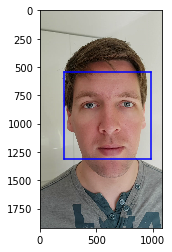

In [5]:
# Draw the face
plt.figure()
plt.imshow(frame)

# Add rectangles on each face
for x,y,w,h in faces:
    plt.plot((x, x+w), (y, y), 'b')
    plt.plot((x, x+w), (y+h, y+h), 'b')
    plt.plot((x, x), (y, y+h), 'b')
    plt.plot((x+w, x+w), (y, y+h), 'b')

# Show the plot
plt.show()

X: 213 - 981
Y: 548 - 1316


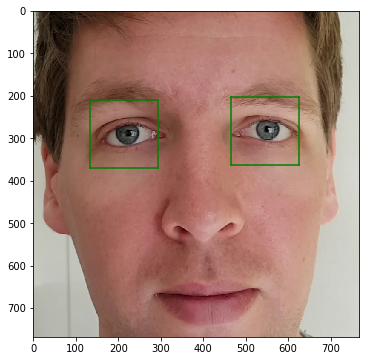

In [6]:
# Preprae the eye cascade
eyeCascPath = 'haarcascade_eye.xml'
eyeCascade = cv2.CascadeClassifier(eyeCascPath)

# Prepare the plot
plt.figure(figsize=(6, 6*len(faces)))
i = 1

for x,y,w,h in faces:
    # Preparethe subplot
    plt.subplot(1,len(faces), i)
    i += 1
    
    # Debug information
    print("X: %d - %d\nY: %d - %d"%(x, x+w, y, y+h))
    
    # Cut out the face
    face_gray  = gray[y:y+h, x:x+w]
    face_color = frame[y:y+h, x:x+w]
    plt.imshow(face_color)
    
    # Detect the eyes
    eyes = eyeCascade.detectMultiScale(
        face_gray,
        scaleFactor = 2,
        minNeighbors = 5,
        minSize = (30,30),
    )
    
    # Draw in the eyes
    for ex, ey, ew, eh in eyes:
        plt.plot((ex, ex+ew), (ey, ey), 'g')
        plt.plot((ex, ex+ew), (ey+eh, ey+eh), 'g')
        plt.plot((ex, ex), (ey, ey+eh), 'g')
        plt.plot((ex+ew, ex+ew), (ey, ey+eh), 'g')
    

In [73]:
# Take on of the eyes
x,y,w,h   = eyes[0]
eye_color = deepcopy(face_color[y:y+h,x:x+w])
eye_gray  = deepcopy(face_gray[y:y+h,x:x+w])
print(np.shape(eye_gray))

circles = cv2.HoughCircles(
    image = eye_gray,
    method = cv2.HOUGH_GRADIENT,
    dp = 1,
    minDist = np.shape(eye_gray)[0] // 4,
    param1 = 100,
    param2 = 30,
    minRadius = np.shape(eye_gray)[0] // 16,
    maxRadius = np.shape(eye_gray)[0] // 4,
)

for c in circles[0]:
    print(c)
    cv2.circle(eye_gray, (c[0], c[1]), c[2], (0,255,0), 2)

cv2.imshow('detected circles', eye_gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

(160, 160)
[97.5 76.5 26. ]


# Combining everything in a movie
In this part, the developed pieces will be combined and applied to every frame

In [106]:
# Create a list to store the results
res = []

# And prepare to write the eye images
video = cv2.VideoWriter(
    'eye_video.avi',
    cv2.VideoWriter_fourcc(*"XVID"),
    frameSize=(160,160),
    fps=60.0,
)

# Check for video files in the folder
folder = '../../../Videos/Original/'
vids = os.listdir(folder)
vid = '20190217_114225.mp4'

# Import the video using opencv
fname = ''.join([folder, vid])
cap = cv2.VideoCapture(fname)

# Prepare the Haar cascade
cascPath = 'haarcascade_frontalface_default.xml'
faceCascade = cv2.CascadeClassifier(cascPath)

# Preprae the eye cascade
eyeCascPath = 'haarcascade_eye.xml'
eyeCascade = cv2.CascadeClassifier(eyeCascPath)

# Loop continously
i = 0
while True:
    # Check whether a frame is available, else quit
    ret, frame = cap.read()
    i += 1
    print("%d - %s"%(i,ret))
    if not ret:
        break
        
    # Rotate the image
    frame = np.transpose(frame, (1,0,2))
        
    # Create a grayscale image from the frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect the faces
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor = 2,
        minNeighbors = 5,
        minSize = (100,100),
    )
    
    # Take the first face
    face_dims = faces[0]
    x,y,w,h = face_dims
    face_gray  = gray[y:y+h, x:x+w]
    face_color = frame[y:y+h, x:x+w]
    
    # Detect the eyes
    eyes = eyeCascade.detectMultiScale(
        face_gray,
        scaleFactor = 2,
        minNeighbors = 5,
        minSize = (30,30),
    )
    
    # Check if we got the right eye
    found = False
    for eye in eyes:
        ex, ey, ew, eh = eye
        if (ex + ew // 2) > (np.shape(face_gray)[0] // 2):
            found = True
            break
    if not found:
        continue
        
    # Cut out the correct piece
    eye_color = deepcopy(face_color[ey:ey+eh,ex:ex+ew])
    eye_gray  = deepcopy(face_gray[ey:ey+eh,ex:ex+ew])
    
    # Detect the irises
    circles = cv2.HoughCircles(
        image = eye_gray,
        method = cv2.HOUGH_GRADIENT,
        dp = 1,
        minDist = np.shape(eye_gray)[0] // 4,
        param1 = 100,
        param2 = 30,
        minRadius = np.shape(eye_gray)[0] // 16,
        maxRadius = np.shape(eye_gray)[0] // 4,
    )
    if type(circles) == type(None):
        continue
    
    # Store the x value of the results
    cx = (circles[0][0][0] + x + ex) // 1
    cy = (circles[0][0][1] + y + ey) // 1
    
    if np.shape(eye_gray)[0] == 160:
        cx_min = int(cx - 80)
        cx_max = int(cx + 80)
        cy_min = int(cy - 80)
        cy_max = int(cy + 80)
        eye_color = deepcopy(frame[cy_min:cy_max, cx_min:cx_max,:])
        video.write(eye_color)
    
    res.append(x)

video.release()
print("Done")

1 - True
2 - True
3 - True
4 - True
5 - True
6 - True
7 - True
8 - True
9 - True
10 - True
11 - True
12 - True
13 - True
14 - True
15 - True
16 - True
17 - True
18 - True
19 - True
20 - True
21 - True
22 - True
23 - True
24 - True
25 - True
26 - True
27 - True
28 - True
29 - True
30 - True
31 - True
32 - True
33 - True
34 - True
35 - True
36 - True
37 - True
38 - True
39 - True
40 - True
41 - True
42 - True
43 - True
44 - True
45 - True
46 - True
47 - True
48 - True
49 - True
50 - True
51 - True
52 - True
53 - True
54 - True
55 - True
56 - True
57 - True
58 - True
59 - True
60 - True
61 - True
62 - True
63 - True
64 - True
65 - True
66 - True
67 - True
68 - True
69 - True
70 - True
71 - True
72 - True
73 - True
74 - True
75 - True
76 - True
77 - True
78 - True
79 - True
80 - True
81 - True
82 - True
83 - True
84 - True
85 - True
86 - True
87 - True
88 - True
89 - True
90 - True
91 - True
92 - True
93 - True
94 - True
95 - True
96 - True
97 - True
98 - True
99 - True
100 - True
101 - Tr

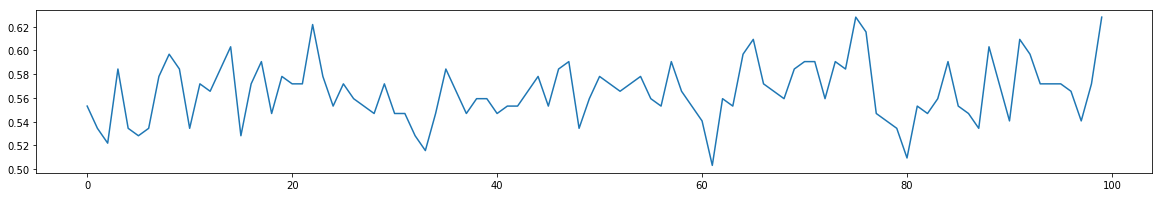

In [69]:
plt.figure(figsize=(20,3))
plt.plot(res[400:500])
plt.show()